**Nem todo modelo precisa ser complexo**
*Uma análise simples e prática do conjunto MNIST (dados de números escritos à mão)*

Algumas partes do código foram adaptadas do livro "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" de Aurélien Géron. O objetivo, no entanto, é compreender as técnicas apresentadas e não apenas reproduzir o código.

In [1]:
#importando pacotes iniciais 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#importando os dados 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [3]:
#verificando o conjunto de dados

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# dividindo os dados 
X, y = mnist["data"], mnist["target"]

In [5]:
# verificando as dimensoes dos dados
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

Até aqui descobrimos que nosso conjunto possui 70k exemplos com 784 features (imagens 28x28)

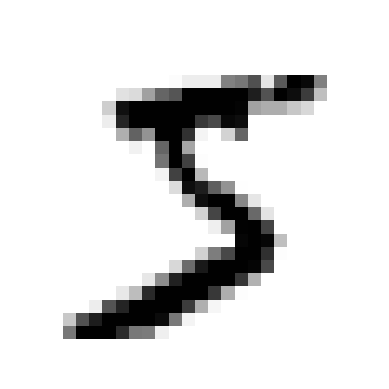

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0] # vamos checar um numero qualquer, no caso o da primeira linha 
some_digit_image = some_digit.reshape(28, 28) # como temos 784 features, vamos redimensionar o tamanho de uma imagem 28 x 28
plt.imshow(some_digit_image, cmap="binary") # "cmap=binary" para usarmos somente a escala de branco e preto.
plt.axis("off") # remove os eixos da imagem, para uma melhor visualizacao 
plt.show()

In [8]:
#vamos verificar se o numero que esta aparecendo realmente se parece com o que está gravado como "alvo"
y[0]

'5'

In [9]:
#Para reduzir a memória utilizada em nosso dataset, vamos converter a variável alvo para ocupar somente 1 byte.
y = y.astype(np.uint8)

Para seguirmos adiante e separarmos nosso conjunto em dados de treinamento e de teste é importante verificarmos se nossos dados são balanceados.

In [10]:
# Transformando os rótulos em um DataFrame
df = pd.DataFrame({'Label': y})

# Contando as ocorrências de cada classe
print(df['Label'].value_counts())

# Exibindo como porcentagem
print(df['Label'].value_counts(normalize=True) * 100)

Label
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64
Label
1    11.252857
7    10.418571
3    10.201429
2     9.985714
9     9.940000
0     9.861429
6     9.822857
8     9.750000
4     9.748571
5     9.018571
Name: proportion, dtype: float64


Como verificamos que os dados são balanceados, podemos usar a acurácia como métrica primária de avaliação. No entanto, pocomplementar com uma matriz de confusão para garantir que o modelo está performando bem em todas as classes.

In [11]:
#Agora, podemos dividir os nossos dados 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

Embora pudéssemos testar diversos classificadores, neste trabalho vamos nos concentrar no K-Nearest Neighbors (KNN), explorando sua simplicidade e aplicabilidade ao conjunto de dados MNIST.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy


0.9688

Nosso modelo está alcançando uma acurácia de 96,88%, o que já é um bom resultado. No entanto, acreditamos que pequenas mudanças, como ajustes nos hiperparâmetros e data augmentation, podem melhorar ainda mais o desempenho.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definindo a grade de hiperparâmetros para explorar
param_grid = [
    {'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}  # Testar diferentes estratégias de peso e vizinhos
]

# Criando o modelo KNN
knn_clf = KNeighborsClassifier()  # Inicializa o classificador KNN com os parâmetros padrão

# Configurando o GridSearchCV para buscar os melhores hiperparâmetros
grid_search = GridSearchCV(
    knn_clf,                  # O modelo que será ajustado
    param_grid,               # A grade de parâmetros a testar
    cv=5,                     # Número de divisões para validação cruzada
    scoring='accuracy',       # Métrica para avaliar os modelos
    n_jobs=-1                 # Paraleliza o processo de busca para maior velocidade
)

# Ajustando o GridSearch aos dados de treinamento 
grid_search.fit(
    X_train,         
    y_train          
)

# Resultado dos melhores parâmetros encontrados
best_params = grid_search.best_params_  # Recupera os melhores hiperparâmetros da busca
best_score = grid_search.best_score_    # Melhor acurácia obtida durante a validação cruzada

# Exibindo os resultados
print("Melhores hiperparâmetros:", best_params)  # Mostra os melhores valores encontrados para 'weights' e 'n_neighbors'
print("Melhor acurácia na validação cruzada:", best_score)  # Mostra a acurácia média na validação cruzada


Melhores hiperparâmetros: {'n_neighbors': 4, 'weights': 'distance'}
Melhor acurácia na validação cruzada: 0.9716166666666666


Agora vamos para a parte de Data Augmentation

In [14]:
#Utilizando a funcao shift para mover a imagem para cima/ baixa/diretia/esquerda
from scipy.ndimage import shift

In [15]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

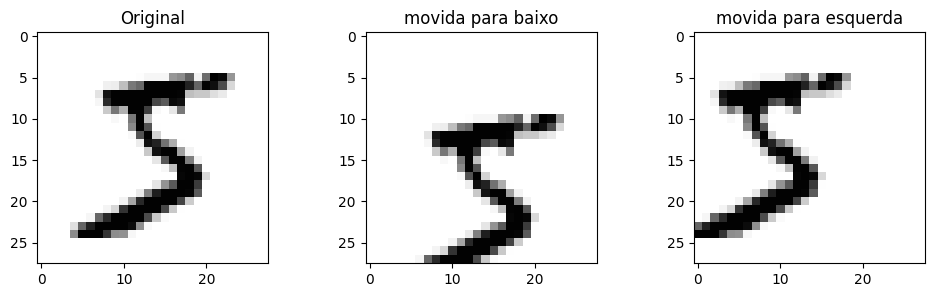

In [16]:
image = X_train[0]  # o mesmo numero usado no inicio
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("movida para baixo")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("movida para esquerda")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()


In [17]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [18]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [19]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [20]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [21]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763